In [ ]:
#%%

### ch5. 金融统计基础
#####################

# 5.1 统计学在金融中的应用
# 5.2 对数收益率的统计分析与正态分布检验
# 5.3 处理多支真实股票数据
# 5.4 蒙特卡洛模拟

In [ ]:
#%%

# 导入相关的包，scipy.stats,statsmodels.api
# pip install numpy pandas matplotlib scipy statsmodels # 安装需要的包
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
import scipy.interpolate as sci
import statsmodels.api as sm

from functions_stat import print_statistics, normality_tests, gen_paths

np.random.seed(42)

            Date       Close        High         Low        Open    Volume  \
2811  2025-11-21  152.929993  155.880005  148.639999  151.979996  16240800   
2812  2025-11-24  160.729996  161.500000  158.699997  160.000000  21796600   
2813  2025-11-25  157.009995  166.369995  156.149994  165.199997  27097500   
2814  2025-11-26  157.600006  161.460007  150.000000  159.095001  21453100   
2815  2025-11-28  157.300003  158.690002  155.679993  156.160004   7185500   

          Diff  CloseOpen  OpenClose    HighLow   returns  Log_Rets  \
2811 -0.350006   0.949997  -0.949997   7.240005 -0.002283 -0.002286   
2812  7.800003   0.729996  -0.729996   2.800003  0.051004  0.049746   
2813 -3.720001  -8.190002   8.190002  10.220001 -0.023144 -0.023416   
2814  0.590012  -1.494995   1.494995  11.460007  0.003758  0.003751   
2815 -0.300003   1.139999  -1.139999   3.010010 -0.001904 -0.001905   

             42d        252d   Mov_Vol  
2811  169.544523  123.872183  0.486047  
2812  169.193570  124.

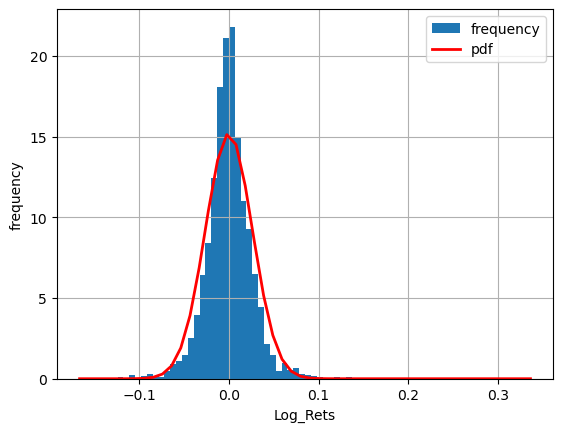


QQ图：观察数据点是否贴线，判断数据是否符合正态分布：


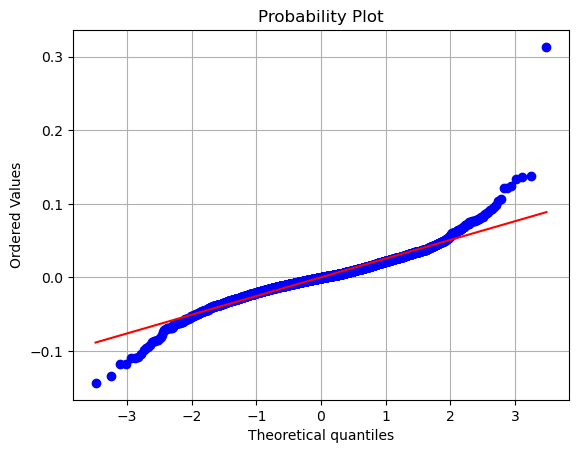

In [ ]:
#%%

### 5.1 统计学在金融中的应用
### #######################

# 描述性统计的输出包括：样本大小（size）、最小值（min）、最大值（max）、均值（mean）、标准差（std）、偏度（skew）、峰度（kurtosis）。

# 正态分布检验包括：偏度检验（skew test）、峰度检验（kurtosis test）、正态性检验（normality test），均返回 p 值，用于判断数据是否符合正态分布假设（通常以 0.05 | 0.10 为显著性水平阈值）。

# 直方图（Histogram）
# 直方图是一种用于展示数据分布特征的图形，将数据按一定区间（bins）分组，统计每个区间内数据的数量（频率），并以条形图的形式展示。
# 直方图的核心作用是展示数据的分布形状（如是否对称、是否集中、是否有异常值等），并帮助识别数据的中心趋势（如均值、中位数等）和离散程度（如标准差、范围等）。
# 可与正态分布（参数r和sigma）的概率密度函数进行比较，以验证数据是否符合正态分布假设。

# QQ 图（Quantile-Quantile Plot，分位数 - 分位数图）
# 核心作用是判断一组数据是否服从某个理论分布（如正态分布、均匀分布、指数分布等），也可用于比较两组数据是否来自同一分布。
# 实操中一般使用 Python 的scipy.stats.probplot 或 statsmodels.api.qqplot 快速绘制，结合统计检验验证结论。

'''
补充知识：偏度与峰度

偏度（Skewness）：衡量分布的“对称性”，值越接近于0越好，大于0右偏，小于0左偏。一般以0.5和1为判断阈值，0.5-1为中度偏态，>1为高度偏态。
峰度（Kurtosis）：衡量分布的“陡峭程度”，值大于0为尖峰，小于0为平缓峰。如果输出的不是excess kurtosis（超额峰度），而是一般的峰度，则以3为判断阈值。峰度大其真实原因有可能是数据中存在异常值（如股票价格中的异常高或低值）。

补充知识： QQ 图的原理与分析规则

分位数匹配：将样本数据的分位数（如最小值、25% 分位数、中位数、75% 分位数、最大值等）与理论分布的分位数一一对应，绘制成散点图。
判断逻辑：若样本数据服从该理论分布，散点会近似落在一条直线上（这条直线是理论分位数与样本分位数的理想对应关系）；偏离直线越明显，说明数据与理论分布的差异越大。

# 如何分析 QQ 图（以最常用的 “正态 QQ 图” 为例）
坐标轴含义
横轴（x 轴）：理论正态分布的分位数（如标准正态分布 N (0,1) 的分位数）；
纵轴（y 轴）：样本数据的分位数（按从小到大排序后，对应理论分位数的位置）。

核心分析规则（看散点是否 “贴线”）

散点分布特征	结论（数据是否符合正态分布）	常见场景
大部分散点近似落在直线上	符合正态分布	实验数据、自然现象数据（如身高、体重）
两端（尾部）明显偏离直线	不符合正态分布	左偏 / 右偏数据、有异常值的数据
    左偏数据：QQ 图左侧（小分位数）散点在直线下方，右侧（大分位数）散点在直线上方 → 数据集中在右侧，存在少量极小值；
    右偏数据：QQ 图左侧散点在直线上方，右侧散点在直线下方 → 数据集中在左侧，存在少量极大值；
    异常值：某个散点明显远离直线（单独 “飘” 在外面） → 该数据为异常值（需进一步验证是否为测量错误）；
均匀分布：散点呈 “S” 形偏离直线 → 数据分布均匀，而非正态。
多峰分布：QQ 图中间部分散点偏离直线，两端部分散点贴近直线 → 数据呈多峰分布，而非正态。
'''

### 5.2 对数收益率的统计分析与正态分布检验析
### ########################################

#从csv读取数据
data = pd.read_csv("./data/stockdata_BABA_TSA.csv",encoding = "gbk")
print(data.tail())
# 因为计算时存在平移，所以前几行会有NaN值。
log_data = np.array(data["Log_Rets"].dropna())

# 为方便引用，自定义函数保存在 functions_stat.py文件中，可通过import导入
from functions_stat import print_statistics, normality_tests
# 自定义数组的描述统计函数 print_statistics
# 自定义数组的正态分布检验函数 normality_tests

print("\n对数收益率的描述性统计：")
print_statistics(log_data)  # baba

print("\n对数收益率的正态分布检验：")
normality_tests(log_data)  # baba

print("\n对数收益率的直方图：观察频数分布情况")
# 直方图，对数收益率的分布，并与正态分布（参数r和sigma）的概率密度函数进行比较
# plt.hist(log_returns.flatten(), bins=70, normed=True, label='frequency')
plt.hist(log_data.flatten(), bins=70, label='frequency', density=True) # 教材上normed参数需要去掉, 要加上 density=True，不然后面的pdf曲线无法正常显示
plt.grid(True)
plt.xlabel('Log_Rets')
plt.ylabel('frequency')
x = np.linspace(plt.axis()[0], plt.axis()[1])
loc = log_data.mean()   # 均值
scale = log_data.std()  # 标准误（scale）
pdf = scs.norm.pdf(x, loc=loc, scale=scale)
plt.plot(x, pdf, 'r', lw=2.0, label='pdf')
plt.legend()
plt.show()

print("\nQQ图：观察数据点是否贴线，判断数据是否符合正态分布：")
scs.probplot(data["Log_Rets"].dropna(), plot=plt)
# dist默认值为 "norm"，也可以指定其他分布（如 "uniform"、"expon" 等）。
# 使用statsmodels.api.qqplot与使用scipy.stats.probplot类似，只是dist参数需要使用scipy.stats.norm
# scs.probplot(data["Log_Rets"].dropna(), dist="norm", plot=plt)
# sm.qqplot(data["Log_Rets"].dropna(), line='s')
# sm.qqplot(data["Log_Rets"].dropna(), line='s', dist=scs.norm)
plt.grid(True)
plt.show()

In [ ]:
#%%

### 5.3 处理多支真实股票数据
### ##########################
# 多支股票分析完整例子(含描述统计与正态分布检验）
# 1. 获取多支股票的Close数据
# 2. 计算每支股票的对数收益率
# 3. 检验每支股票的对数收益率是否服从正态分布

# 导入必要的包
import datetime
import numpy as np
import pandas as pd
import tushare as ts
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.api as sm
from functions_stat import print_statistics, normality_tests

# 定义股票代码列表
symbols = ['600755.SH', '600309.SH', '600031.SH', '600886.SH', '000768.SZ', '002594.SZ', '000651.SZ', '600138.SH', '600177.SH', '600276.SH', '600519.SH', '002714.SZ', '600036.SH', '601318.SH', '000002.SZ', '601138.SH', '600111.SH', '300413.SZ', '002093.SZ']
# 注释对应的公司名称
comp_name = ['xmgm', 'whhx', 'syzg', 'gtdl', 'zhxf', 'byd', 'gldq', 'zql', 'yge', 'hryy', 'gzmt', 'mygf', 'zsyh', 'zgpa', 'wka', 'gyfl', 'bfxt', 'mgcm', 'gmkj']
# 组合成字典方便后续引用
comp_list = dict(zip(symbols, comp_name))

In [ ]:
#%%

# # 使用tushare获取多支股票的收盘数据并存入csv文件

# pro = ts.pro_api('aac3815814723db39100bf3cecbb0b2b73144da433d708d77d1f4c5e')
# start='20150101'
# end=datetime.datetime.now().strftime('%Y%m%d')

# pd.set_option('display.max_columns',None) #显示所有列
# pd.set_option('display.max_rows',None) # 显示所有行
# data = pd.DataFrame()

# for code in symbols:
#     data[code] = pro.daily(ts_code=code, start_date=start, end_date=end)["close"]
# print(data.head())

# datareverse=data.iloc[::-1] #data按行逆序,将时间序列从旧到新排列
# datareverse.index=range(1,len(datareverse)+1)

# print(datareverse.head())
# print(datareverse.tail())
# print(datareverse.describe())

# outputfile = './data/stockdata-tushare-2025.csv'
# datareverse.to_csv(outputfile)

<ipython-input-6-40065cd8326f>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data1 = pd.read_csv("./data/stockdata-tushare-2025.csv", encoding="gbk", index_col=0, parse_dates=True)  # 从csv读取数据


     600755.SH  600309.SH  600031.SH  600886.SH  000768.SZ  002594.SZ  \
836       8.40      37.62       8.16       7.45      15.61      50.13   
837       8.18      37.94       8.24       7.51      15.76      49.42   
838       8.06      40.08       8.71       7.55      15.81      50.03   
839       8.13      44.09       8.68       7.71      15.33      49.06   
840       8.02      45.52       8.62       7.79      15.11      49.05   

     000651.SZ  600138.SH  600177.SH  600276.SH  600519.SH  002714.SZ  \
836      47.50      22.45       8.05      81.15     777.95      50.55   
837      46.58      21.52       8.12      78.02     775.73      50.22   
838      47.81      22.42       8.16      78.66     799.19      50.33   
839      48.55      22.13       8.16      77.03     790.33      50.46   
840      48.41      21.74       8.18      76.29     786.13      49.70   

     600036.SH  601318.SH  000002.SZ  601138.SH  600111.SH  300413.SZ  \
836      28.20      62.39      26.71      19.83  

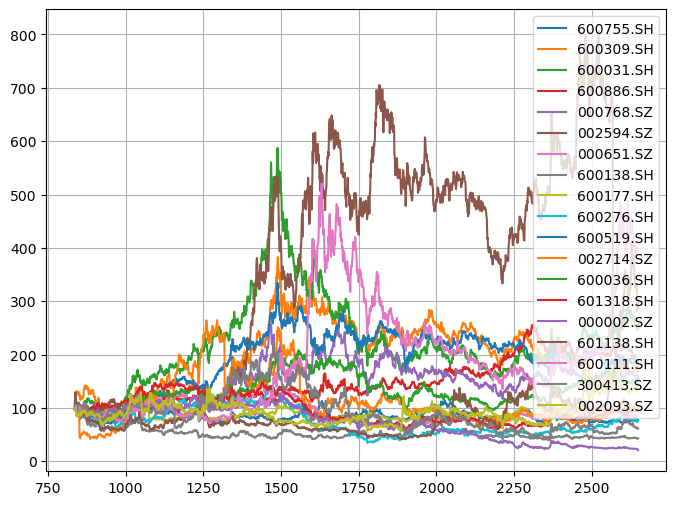

In [ ]:
#%%

# 读取CSV数据
data1 = pd.read_csv("./data/stockdata-tushare-2025.csv", encoding="gbk", index_col=0, parse_dates=True)  # 从csv读取数据

datareverse = data1[symbols]
datareverse = datareverse.dropna()
# print(datareverse.info())
print(datareverse.head())

# 绘制股票价格的归一化曲线
(datareverse / datareverse.iloc[0] * 100).plot(figsize=(8, 6), grid=True)
plt.show()

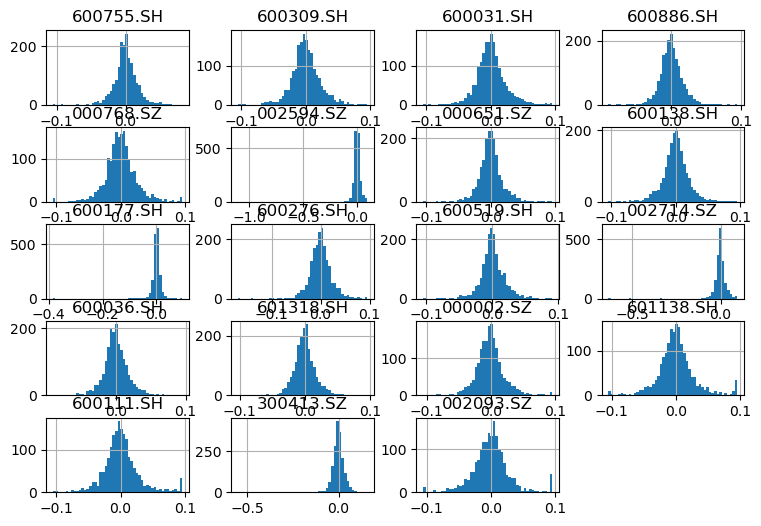

In [ ]:
#%%

# 计算对数收益率并绘制直方图
log_returns = np.log(datareverse / datareverse.shift(1))
log_returns.head()
log_returns.hist(bins=50, figsize=(9, 6))
plt.show()

In [ ]:
#%%

# 多支股票的统计分析与正态分布检验
for sym in symbols:
    print(f"\nResults for symbol {sym}({comp_list[sym]})")
    print(30 * "-")
    log_data = np.array(log_returns[sym].dropna())
    print_statistics(log_data)  # abc
    print(32 * "-")
    normality_tests(log_data) 


Results for symbol 600755.SH(xmgm)
------------------------------
     statistic           value
------------------------------
          size      1813.00000
           min        -0.10587
           max         0.08232
          mean        -0.00014
           std         0.01795
          skew        -0.47645
      kurtosis         5.26552
--------------------------------
Skew of data set          -0.476
Skew test p-value          0.000
Kurt of data set           5.266
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol 600309.SH(whhx)
------------------------------
     statistic           value
------------------------------
          size      1813.00000
           min        -0.10539
           max         0.09547
          mean         0.00031
           std         0.02258
          skew         0.16859
      kurtosis         2.33046
--------------------------------
Skew of data set           0.169
Skew test p-value          0.003
Kurt of dat

QQ图


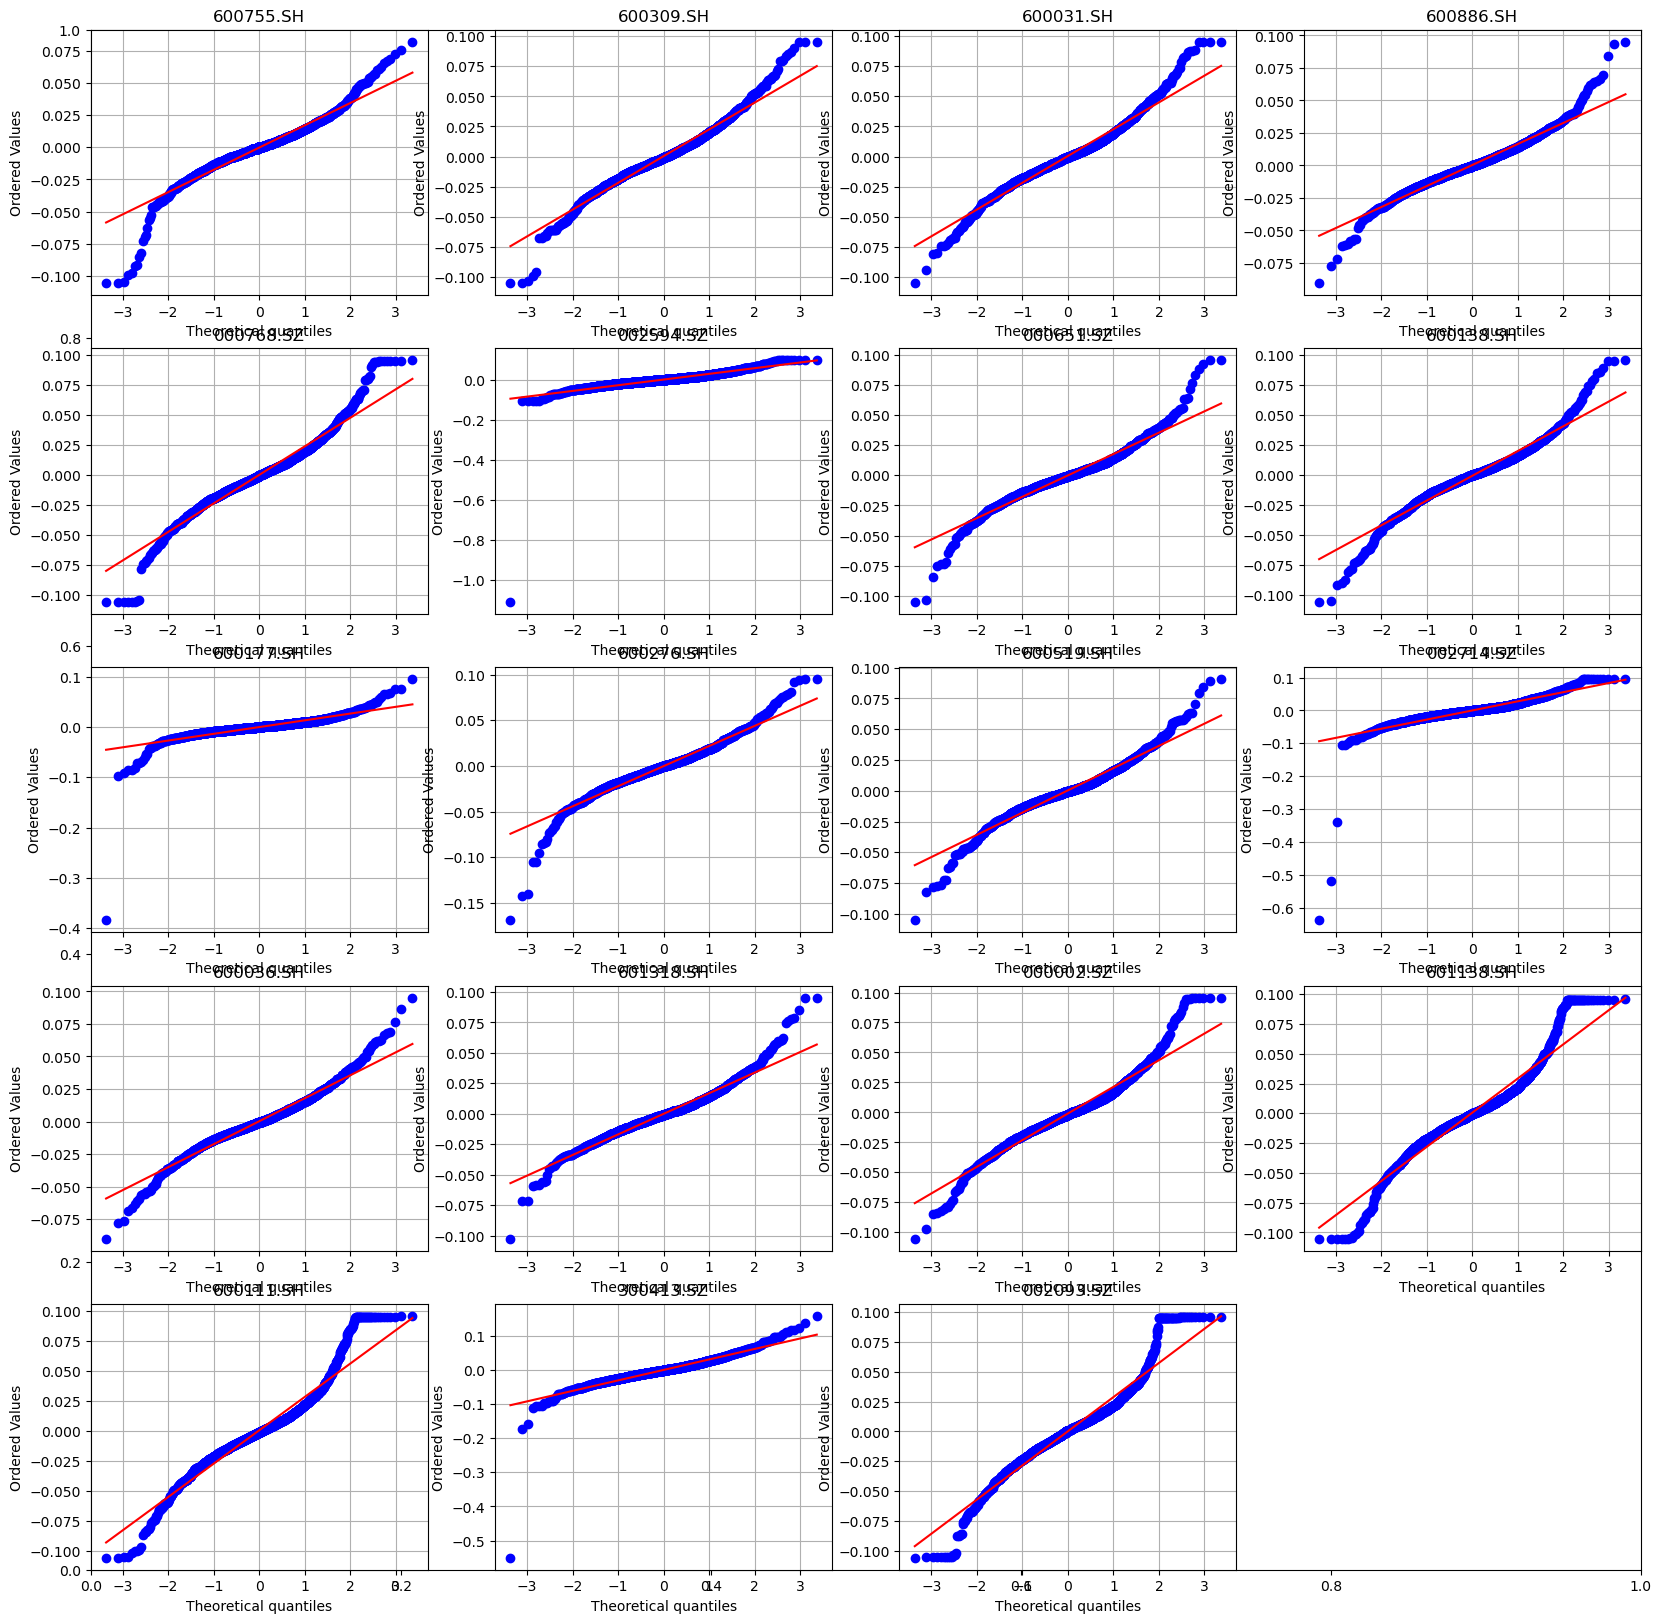

In [ ]:
#%%

# 绘制多支股票的QQ图
num_subplot = 0
print("QQ图")
plt.subplots(figsize=(20, 20))
for sym in symbols:
    num_subplot += 1
    plt.subplot(5,  4,  num_subplot)  
    scs.probplot(log_returns[sym].dropna(), plot=plt)
    plt.grid(True)
    plt.title(f'{sym}') 

plt.show()


前10条模拟路径：


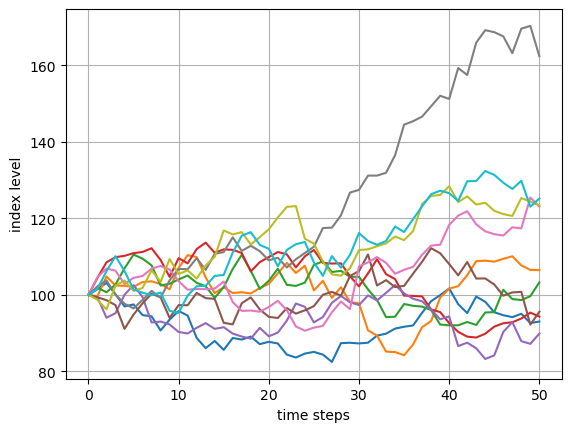

In [ ]:
#%%

# 5.4 蒙特卡洛模拟
###################

# 根据指定参数生成路径，并展示前十条路径
import numpy as np
import matplotlib.pyplot as plt
from functions_stat import gen_paths

# 设置初始参数
S0 = 100. # 初始指数水平
r = 0.05  # 无风险短期利率常数
sigma = 0.2  # 波动率常数
T = 1.0  # 模拟时间长度
M = 50   # 模拟路径数
I = 250000  # 模拟步数

# 根据指定参数生成路径
paths = gen_paths(S0, r, sigma, T, M, I)
print('\n前10条模拟路径：')
plt.plot(paths[:, :10])
plt.grid(True)
plt.xlabel('time steps')
plt.ylabel('index level')
plt.show()

第1条模拟路径的收益值: 
[100.     101.475  103.147  100.1532  96.9885  97.5123  94.7274  94.4149
  90.7262  93.55    95.8008  94.6126  88.7744  86.0893  87.9811  85.6354
  88.7472  88.3433  89.1078  87.1443  87.7582  87.3075  84.4031  83.6454
  84.6734  85.1204  84.4059  82.4976  87.4067  87.5054  87.3299  87.5172
  89.3713  89.8694  91.206   91.6819  92.0325  95.34    98.3711  99.9385
 101.6825  97.5828  95.2533  99.5693  98.2068  95.4747  94.7021  94.196
  95.0718  92.649   93.053 ]
第1条模拟路径的对数收益率: 
[ 0.0146  0.0163 -0.0295 -0.0321  0.0054 -0.029  -0.0033 -0.0399  0.0306
  0.0238 -0.0125 -0.0637 -0.0307  0.0217 -0.027   0.0357 -0.0046  0.0086
 -0.0223  0.007  -0.0051 -0.0338 -0.009   0.0122  0.0053 -0.0084 -0.0229
  0.0578  0.0011 -0.002   0.0021  0.021   0.0056  0.0148  0.0052  0.0038
  0.0353  0.0313  0.0158  0.0173 -0.0412 -0.0242  0.0443 -0.0138 -0.0282
 -0.0081 -0.0054  0.0093 -0.0258  0.0044]
     statistic           value
------------------------------
          size  12500000.00000
    

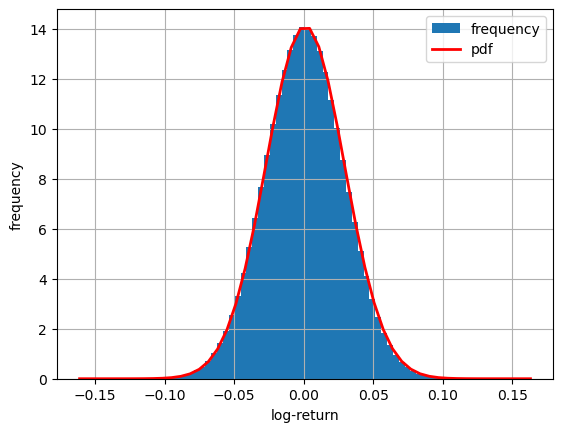

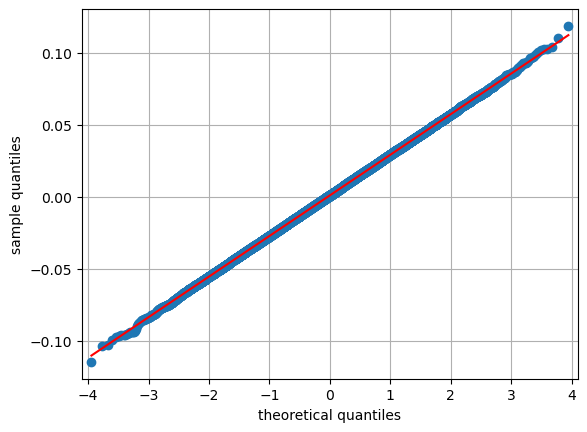

In [ ]:
# %%

# 模拟数据统计分析及正态检验
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.api as sm
from functions_stat import print_statistics, normality_tests

# 特定路径（如第一条路径）的统计分析
log_returns = np.log(paths[1:] / paths[0:-1])  # 对数收益率
print("第1条模拟路径的收益值: ")
print(paths[:, 0].round(4))
print("第1条模拟路径的对数收益率: ")
print(log_returns[:, 0].round(4))
# 输出对数收益率的统计信息
# flatten函数是将多维数组转化为包含所有数据的一维数组
print_statistics(log_returns.flatten()) # 对数收益率的统计信息
# 显示正态分布检验结果
normality_tests(log_returns.flatten())

# 直方图，对数收益率的分布，并与正态分布（参数r和sigma）的概率密度函数进行比较
# plt.hist(log_returns.flatten(), bins=70, normed=True, label='frequency')
plt.hist(log_returns.flatten(), bins=70, label='frequency', density=True) # 教材上normed参数需要去掉, 要加上 density=True，不然后面的pdf曲线无法正常显示
plt.grid(True)
plt.xlabel('log-return')
plt.ylabel('frequency')
x = np.linspace(plt.axis()[0], plt.axis()[1])
loc = r / M          # 均值
scale = sigma / np.sqrt(M)  # 标准误（scale）
pdf = scs.norm.pdf(x, loc=loc, scale=scale)
plt.plot(x, pdf, 'r', lw=2.0, label='pdf')
plt.legend()
plt.show()

# 使用QQ图进行预分析
sm.qqplot(log_returns.flatten()[::500], line='s')
plt.grid(True)
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')
plt.show()

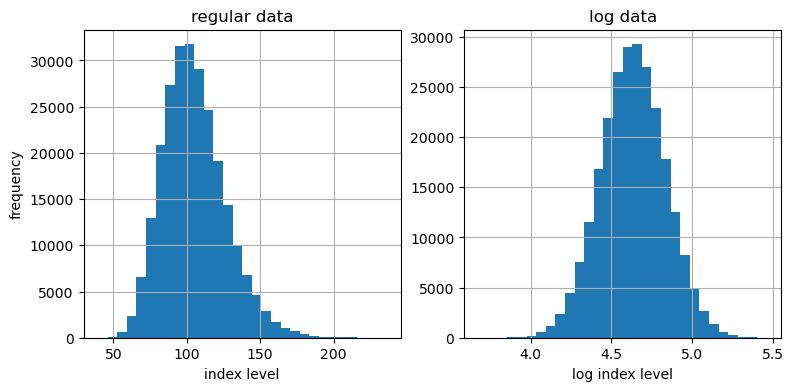

     statistic           value
------------------------------
          size    250000.00000
           min        39.51935
           max       235.93547
          mean       105.14508
           std        21.32532
          skew         0.60902
      kurtosis         0.63838
     statistic           value
------------------------------
          size    250000.00000
           min         3.67679
           max         5.46356
          mean         4.63517
           std         0.20089
          skew        -0.00538
      kurtosis         0.00291
Skew of data set          -0.005
Skew test p-value          0.272
Kurt of data set           0.003
Kurt test p-value          0.761
Norm test p-value          0.522


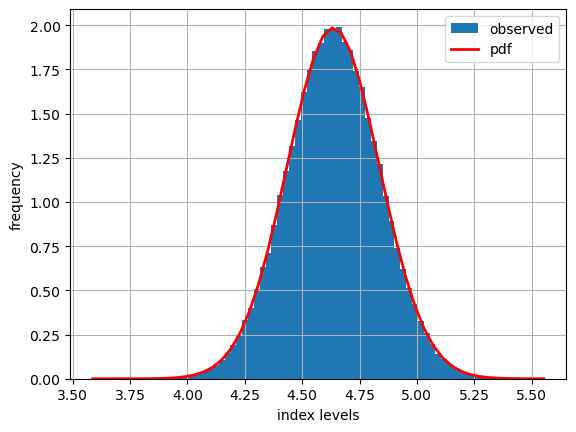

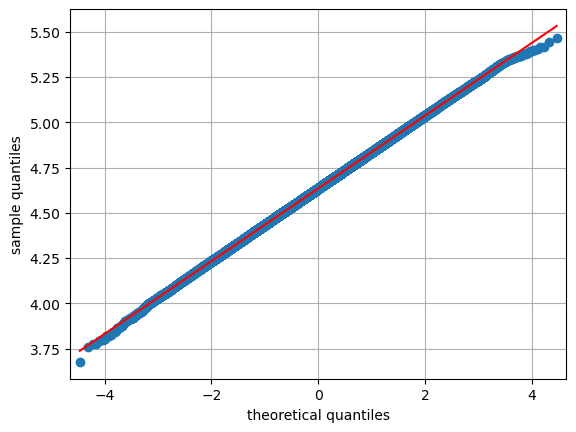

In [ ]:
#%%

# 检查期末值是否呈现正态分布
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.hist(paths[-1], bins=30)
ax1.grid(True)
ax1.set_xlabel('index level')
ax1.set_ylabel('frequency')
ax1.set_title('regular data')
ax2.hist(np.log(paths[-1]), bins=30)
ax2.grid(True)
ax2.set_xlabel('log index level')
ax2.set_title('log data')
plt.show()

print_statistics(paths[-1]) #期末值的统计信息
print_statistics(np.log(paths[-1])) #对数指数水平的偏度与峰度
normality_tests(np.log(paths[-1])) #查看显著性水平

log_data = np.log(paths[-1])
plt.hist(log_data, bins=70, label='observed', density=True)
plt.grid(True)
plt.xlabel('index levels')
plt.ylabel('frequency')
x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.plot(x, scs.norm.pdf(x, log_data.mean(), log_data.std()),'r', lw=2.0, label='pdf')
plt.legend()
plt.show()

sm.qqplot(log_data, line='s')
plt.grid(True)
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')
plt.show()

In [ ]:
# %%

############################END#############################